<a href="https://colab.research.google.com/github/RichardHarwood/root_hairs_rhizosphere_soil/blob/main/Pore_Network_Paper_R_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# from google.colab import drive
# drive.mount('/content/drive')

In [18]:
#!pip install wget

In [19]:
#DOWNLOAD DATA TO COLAB SESSION - NOTE THIS IS TEMP, I WOULD ALWAYS SAVE TO GOOGLE DRIVE BUT THAT ADDS ANOTHER STEP
import wget
wget.download("https://zenodo.org/records/15009078/files/"+"region_df.csv"+"?download=1", out='region_df.csv')
wget.download("https://zenodo.org/records/15009078/files/"+"throat_length_df.csv"+"?download=1", out='throat_length_df.csv')
wget.download("https://zenodo.org/records/15009078/files/"+"throat_inscribed_diameter_df.csv"+"?download=1", out='throat_inscribed_diameter_df.csv')
wget.download("https://zenodo.org/records/15009078/files/"+"tau_data_df.csv"+"?download=1", out='tau_data_df.csv')


'tau_data_df.csv'

In [20]:
# Really there is no real reason to use R (given the image analysis was done in Python),
#essentially I just started playing around in R and never bothered to revert back to Python (I had some usauble ggplot code)

In [21]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [22]:
%%R
#install.packages("ggpubr")
library(tidyverse)
#library(ggpubr)
my_theme    <- theme(axis.text.x = element_text( color="black", size=30, angle=0),
                     panel.border = element_rect(fill = "NA", colour = "black", size = 2),
                     panel.background = element_blank(),
                     plot.title = element_text(size=37),
                     axis.text.y = element_text( color="black", size=30),
                     axis.title.y = element_text(color="black", size=25),
                     legend.position = "none")

In [23]:
%%R
custom_colors <- c("black", "red" )

In [24]:
%%R
pore_regions_df_url = ('/content/region_df.csv')
pore_regions_df = read.csv(pore_regions_df_url)
pore_regions_df$plant<-as.factor(pore_regions_df$plant)
pore_regions_df$ring<-as.factor(pore_regions_df$ring)
pore_regions_df<-pore_regions_df %>% filter(!grepl('W1_', plant  ))

 pore_regions_df<-pore_regions_df %>%
  mutate()%>%
  mutate(plant = case_when(plant=="W16_"~"Wheat",
                           plant=="BALDY"~"Barley (brb)",
                           plant=="BARLEYWT"~"Barley (wt)"))  %>%
  mutate(ring = case_when(ring=="1mm"~"Rhizosphere",
                           ring=="bulk_soil"~"Bulk Soil"))

 pore_regions<-pore_regions_df %>%
  group_by(IMAGE_ID,plant, ring) %>%
  mutate(region_volume_mm = region_volume/1000000000) %>%
  summarise(pore_count  = length(region_volume),
            pore_volume_total  = sum(region_volume_mm, na.rm=TRUE),
            average_region_size_median = median(region_volume_mm, na.rm=TRUE),
            average_region_size_mean = mean(region_volume_mm, na.rm=TRUE)) %>%
  mutate(pore_number_over_volume=pore_count/pore_volume_total)

`summarise()` has grouped output by 'IMAGE_ID', 'plant'. You can override using
the `.groups` argument.


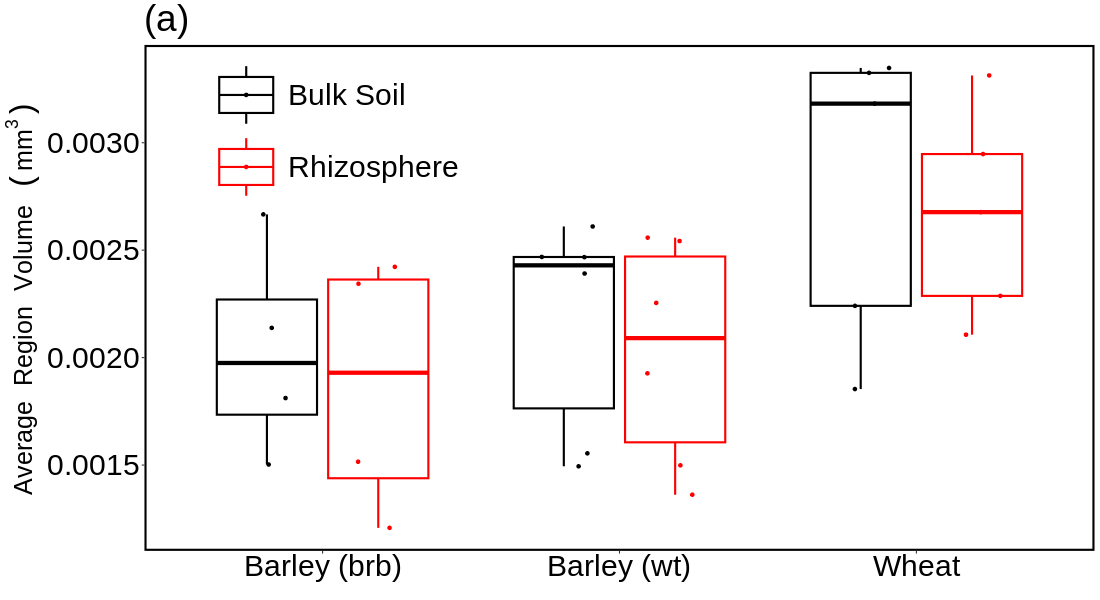

In [25]:
 %%R  -w 1100 -h 600 -u px
pore_regions_gg<-pore_regions %>%
  ggplot(aes(x=plant, y=average_region_size_mean))+
  ggtitle(("(a)"))+
  geom_boxplot(aes(x=as.factor(plant), y=average_region_size_mean,color=as.factor(ring)),outlier.shape = NA, size=1)+
  geom_point(aes(color= ring), alpha = 1,
             position = position_jitterdodge(jitter.width = 0.2))+
  labs(y=(bquote(Average~Region~Volume~(mm^3))), x = "",element_text(size = 6))+
  my_theme+
  theme(legend.key.size = unit(5,"line"))+
  scale_color_manual(values = custom_colors)+
  theme(legend.text = element_text(size=30))+
  theme(legend.position=c(.2,.83))+
  theme(legend.title=element_blank());pore_regions_gg

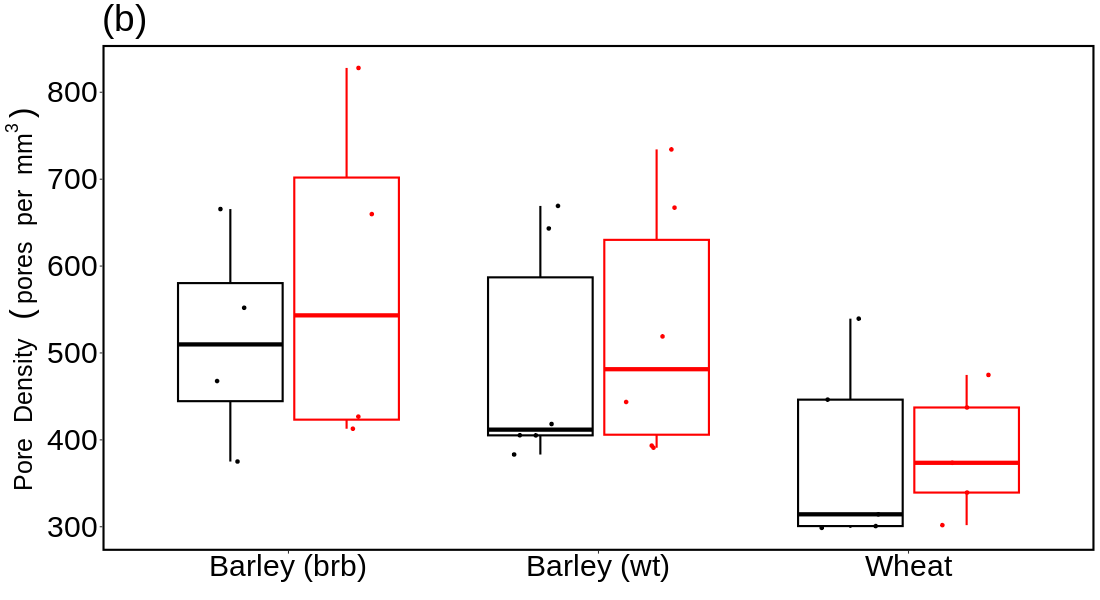

In [26]:
 %%R  -w 1100 -h 600 -u px
pore_number_gg<-pore_regions %>%
  ggplot(aes(x=plant, y=pore_number_over_volume))+
  ggtitle(("(b)"))+
  geom_boxplot(aes(x=as.factor(plant), y=pore_number_over_volume,color=ring),outlier.shape = NA, size=1)+
  geom_point(aes(color= ring), alpha = 1,
             position = position_jitterdodge(jitter.width = 0.2))+
  labs(y=(bquote(Pore~Density~(pores~per~mm^3))), x = "",element_text(size = 6))+
  scale_color_manual(values = custom_colors)+
  my_theme;pore_number_gg

In [27]:
%%R
#Throat Length
throat_length_df_url = ('/content/throat_length_df.csv')
throat_length_df = read.csv(throat_length_df_url)

throat_length_df$plant<-as.factor(throat_length_df$plant)
throat_length_df$ring<-as.factor(throat_length_df$ring)
throat_length_df<-throat_length_df %>% filter(!grepl('W1_', plant  ))%>%
  mutate(plant = case_when(plant=="W16_"~"Wheat",
                           plant=="BALDY"~"Barley (brb)",
                           plant=="BARLEYWT"~"Barley (wt)"))   %>%
  mutate(ring = case_when(ring=="1mm"~"Rhizosphere",
                           ring=="bulk_soil"~"Bulk Soil"))

throat_length<-throat_length_df %>%
  group_by(IMAGE_ID,plant, ring) %>%
  summarise(throat_count  = length(throat_length),
            throat_length_total  = sum(throat_length, na.rm=TRUE),
            average_throat_length_median = median(throat_length, na.rm=TRUE),
            average_throat_length_mean = mean(throat_length, na.rm=TRUE)) %>%
  left_join(pore_regions) %>%
  mutate(throat_number_over_volume=throat_count/pore_volume_total)


`summarise()` has grouped output by 'IMAGE_ID', 'plant'. You can override using
the `.groups` argument.
Joining with `by = join_by(IMAGE_ID, plant, ring)`


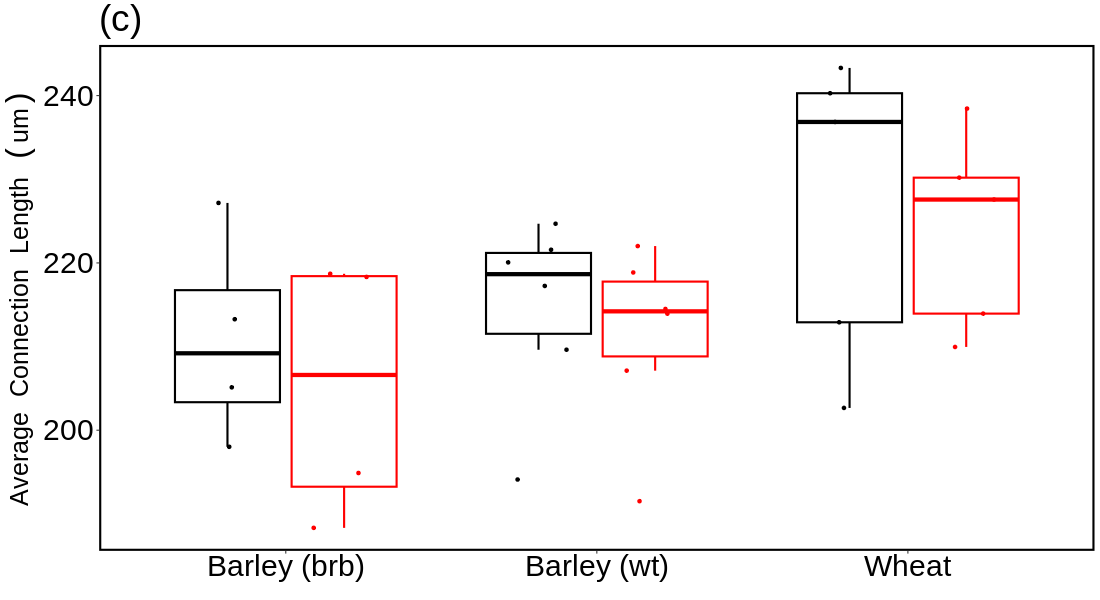

In [28]:
 %%R  -w 1100 -h 600 -u px
throat_length_gg<-throat_length %>%
  ggplot(aes(x=plant, y=average_throat_length_mean))+
  ggtitle(("(c)"))+
  geom_boxplot(aes(x=as.factor(plant), y=average_throat_length_mean,color=ring),outlier.shape = NA, size=1)+
  geom_point(aes(color= ring), alpha = 1,
             position = position_jitterdodge(jitter.width = 0.2))+
  labs(y=(bquote(Average~Connection~Length~(um))), x = "",element_text(size = 6))+
  scale_color_manual(values = custom_colors)+
  my_theme;throat_length_gg

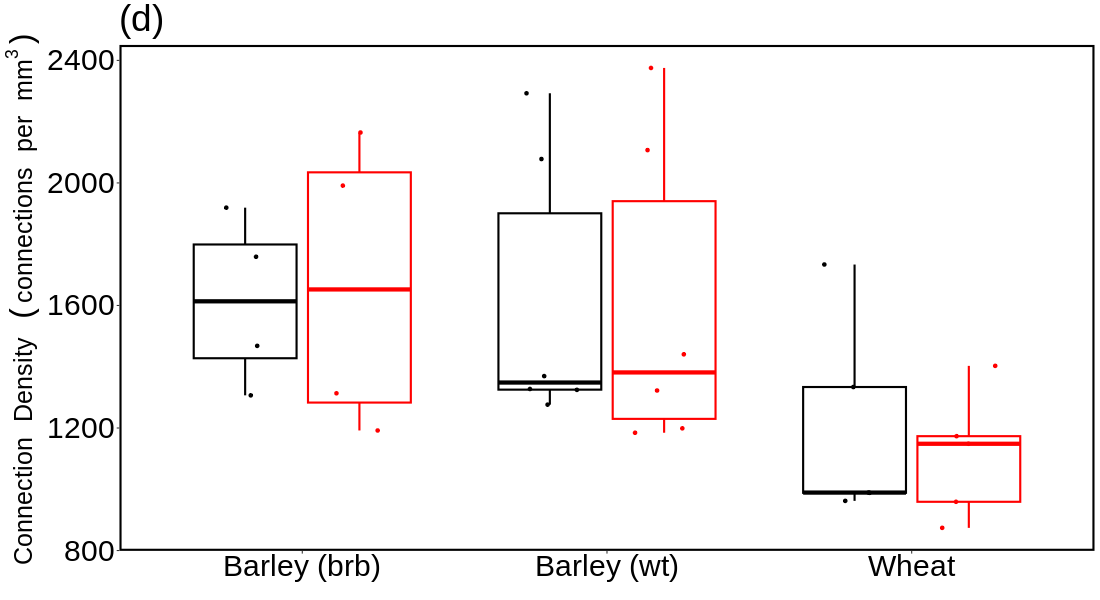

In [29]:
 %%R  -w 1100 -h 600 -u px
throat_count_gg<-throat_length %>%
  ggplot(aes(x=plant, y=throat_number_over_volume))+
  ggtitle(("(d)"))+
  geom_boxplot(aes(x=as.factor(plant), y=throat_number_over_volume,color=ring),outlier.shape = NA, size=1)+
  geom_point(aes(color= ring), alpha = 1,
             position = position_jitterdodge(jitter.width = 0.2))+
  labs(y=(bquote(Connection~Density~(connections~per~mm^3))), x = "",element_text(size = 6))+
  scale_color_manual(values = custom_colors)+
  my_theme;throat_count_gg

In [31]:
 %%R
#Trhoat diameter
throat_inscribed_diameter_df_url = ('/content/throat_inscribed_diameter_df.csv')
throat_diameter_df = read.csv(throat_inscribed_diameter_df_url)
throat_diameter_df$plant<-as.factor(throat_diameter_df$plant)
throat_diameter_df$ring<-as.factor(throat_diameter_df$ring)
throat_diameter_df<-throat_diameter_df %>% filter(!grepl('W1_', plant  ))%>%
  mutate(plant = case_when(plant=="W16_"~"Wheat",
                           plant=="BALDY"~"Barley (brb)",
                           plant=="BARLEYWT"~"Barley (wt)")) %>%
  mutate(ring = case_when(ring=="1mm"~"Rhizosphere",
                          ring=="bulk_soil"~"Bulk Soil"))

throat_diameter<-throat_diameter_df %>%
  group_by(IMAGE_ID,plant, ring) %>%
  summarise(throat_count  = length(throat_inscribed_diameter),
            average_throat_diameter_median = median(throat_inscribed_diameter, na.rm=TRUE),
            average_throat_diameter_mean = mean(throat_inscribed_diameter, na.rm=TRUE))

`summarise()` has grouped output by 'IMAGE_ID', 'plant'. You can override using
the `.groups` argument.


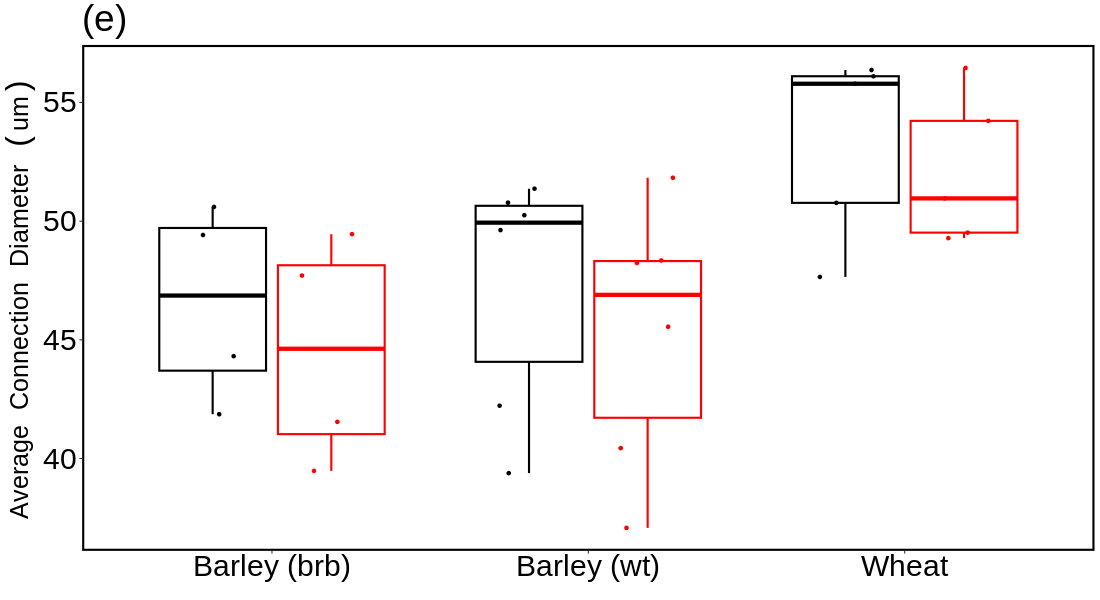

In [32]:
 %%R  -w 1100 -h 600 -u px
throat_diameter_gg<-throat_diameter %>%
  ggplot(aes(x=plant, y=average_throat_diameter_mean))+
  ggtitle(("(e)"))+
  geom_boxplot(aes(x=as.factor(plant), y=average_throat_diameter_mean,color=ring),outlier.shape = NA, size=1)+
  geom_point(aes(color= ring), alpha = 1,
             position = position_jitterdodge(jitter.width = 0.2))+
  labs(y=(bquote(Average~Connection~Diameter~(um))), x = "",element_text(size = 6))+
  scale_color_manual(values = custom_colors)+
  my_theme;throat_diameter_gg


In [33]:
%%R
#Random walk

tau_data_df_url = ('/content/tau_data_df.csv')
tau_data_df = read.csv(tau_data_df_url)

tau_data_df$plant<-as.factor(tau_data_df$plant)
tau_data_df$ring<-as.factor(tau_data_df$ring)
tau_data_df<-tau_data_df %>% filter(!grepl('W1_', plant  ))%>%
  mutate(plant = case_when(plant=="W16_"~"Wheat",
                           plant=="BALDY"~"Barley (brb)",
                           plant=="BARLEYWT"~"Barley (wt)"))  %>%
  mutate(ring = case_when(ring=="1mm"~"Rhizosphere",
                          ring=="bulk_soil"~"Bulk Soil"))

bulk_vs_rhizo<-tau_data_df %>%
  filter(MSD_ID=="msd_all_axis")



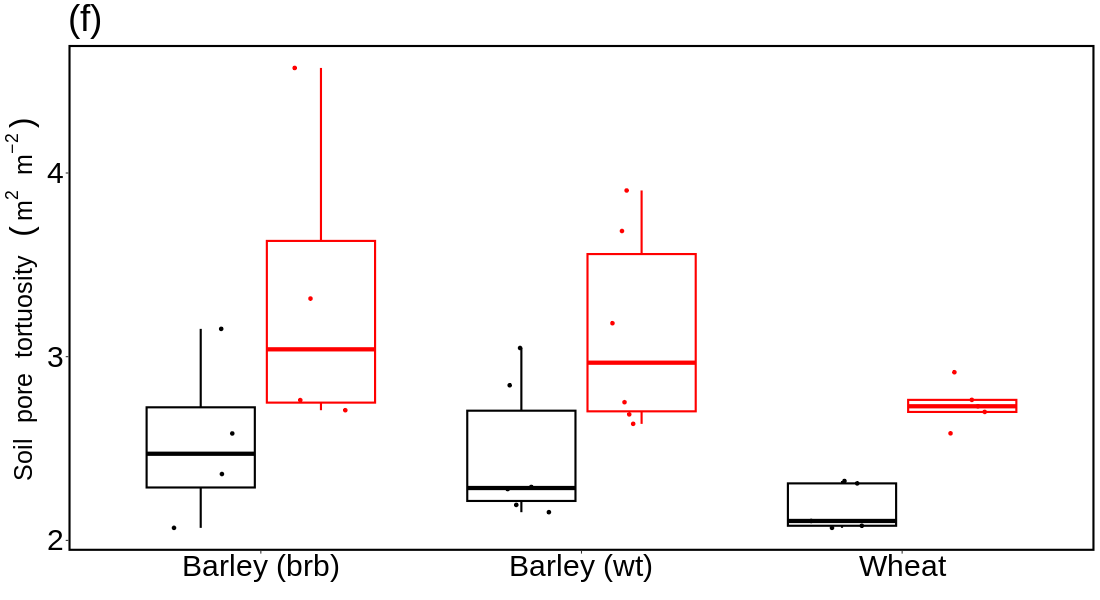

In [34]:
 %%R  -w 1100 -h 600 -u px
 rhizo_vs_bulk_tau_gg<-bulk_vs_rhizo %>%
  ggplot(aes(x=plant, y=TAU_3D))+

  geom_boxplot(aes(x=as.factor(plant), y=TAU_3D ,color=ring),outlier.shape = NA, size=1)+
  geom_point(aes(color= ring), alpha = 1,
             position = position_jitterdodge(jitter.width = 0.2))+
  labs(y=(bquote(Soil~pore~tortuosity~(m^2~m^-2))), x = "",element_text(size = 6))+
  ggtitle(("(f)"))+
  theme(legend.title=element_blank())+
  scale_color_manual(values = custom_colors)+
  # theme(legend.key.size = unit(5,"line"))+
  # theme(legend.text = element_text(size=30))+
  # theme(legend.position=c(.2,.83))+
  my_theme;rhizo_vs_bulk_tau_gg

In [35]:
# %%R
#needs ggpubr, slow to install
# pore_volume_stat=compare_means(average_region_size_mean ~ plant, data = pore_regions, group.by="ring");pore_volume_stat

In [37]:
 %%R
#CALCULATE SOIL SIZE CLASSES

#Macropore
macropore_diameter_min=75 #um
macropore_volume_min=(((4/3)*pi)*(macropore_diameter_min/2)^3)/1e+9 #mm^3
macropore_diameter_max=500 #um
macropore_volume_max=(((4/3)*pi)*(macropore_diameter_max/2)^3)/1e+9 #mm^3

# mesopores
mesopores_diameter_min=30 #um
mesopores_volume_min=(((4/3)*pi)*(mesopores_diameter_min/2)^3)/1e+9 #mm^3
mesopores_diameter_max=75 #um
mesopores_volume_max=(((4/3)*pi)*(mesopores_diameter_max/2)^3)/1e+9 #mm^3

# biopores
biopores_diameter_min=500 #um
biopores_volume_min=(((4/3)*pi)*(biopores_diameter_min/2)^3)/1e+9 #mm^3
biopores_diameter_max=5000 #um
biopores_volume_max=(((4/3)*pi)*(biopores_diameter_max/2)^3)/1e+9 #mm^3

# micropores
micropores_diameter_min=0.5 #um
micropores_volume_min=(((4/3)*pi)*(micropores_diameter_min/2)^3)/1e+9 #mm^3
micropores_diameter_max=30 #um
micropores_volume_max=(((4/3)*pi)*(micropores_diameter_max/2)^3)/1e+9 #mm^3


pore_regions_size_no_cat=
  pore_regions_df%>%
  group_by(IMAGE_ID,plant, ring) %>%
  summarise(pore_count_total_no_cat  = length(region_volume),
            pore_volume_total_no_cat  = sum(region_volume_mm, na.rm=TRUE))


pore_regions_classes<-pore_regions_df%>%
  mutate(category = case_when((region_volume_mm < macropore_volume_max & region_volume_mm > macropore_volume_min)~"macropores",
                              (region_volume_mm < mesopores_volume_max & region_volume_mm > mesopores_volume_min)~"mesopores",
                              (region_volume_mm < biopores_volume_max & region_volume_mm > biopores_volume_min)~"biopores",
                              (region_volume_mm < micropores_volume_max & region_volume_mm > micropores_volume_min)~"micropores")) %>%
  group_by(IMAGE_ID,plant, ring,category) %>%
  summarise(pore_count  = length(region_volume),
            pore_volume_total  = sum(region_volume_mm, na.rm=TRUE)) %>%
  left_join(pore_regions_size_no_cat) %>%
  mutate(percentage_in_each_class_pores =(pore_count/pore_count_total_no_cat)*100   )


`summarise()` has grouped output by 'IMAGE_ID', 'plant'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'IMAGE_ID', 'plant', 'ring'. You can
override using the `.groups` argument.
Joining with `by = join_by(IMAGE_ID, plant, ring)`


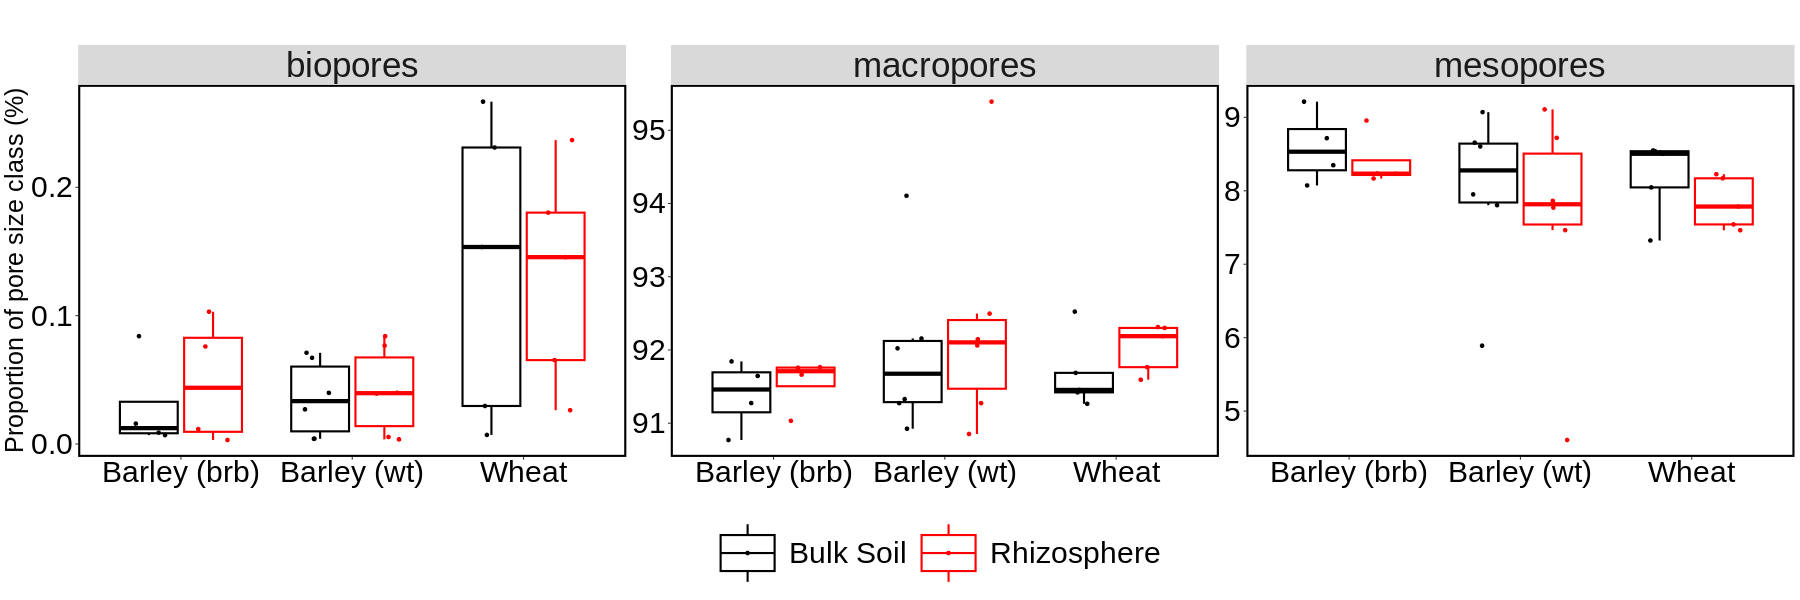

In [41]:
 %%R  -w 1800 -h 600 -u px
pore_regions_classes_gg<-pore_regions_classes%>%
  ggplot(aes(x=plant, y=percentage_in_each_class_pores))+
  ggtitle((""))+
  geom_boxplot(aes(x=as.factor(plant), y=percentage_in_each_class_pores ,color=ring),outlier.shape = NA, size=1)+
  geom_point(aes(color= ring), alpha = 1,
             position = position_jitterdodge(jitter.width = 0.2))+
  labs(y="Proportion of pore size class (%)", x = "",element_text(size = 6))+
  my_theme+
  theme(legend.key.size = unit(5,"line"))+
  theme(legend.text = element_text(size=30))+
  theme(strip.text = element_text(size = 35))+
  theme(legend.title=element_blank())+
  scale_color_manual(values = custom_colors)+
  theme(legend.position="bottom")+facet_wrap(~category, scales="free");pore_regions_classes_gg